In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

warnings.simplefilter(action="ignore", category=FutureWarning)
import sys

sys.path.append("../")

import optuna

from straindesignxai.main import DataLoader

RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

Dataset size: (30, 10)


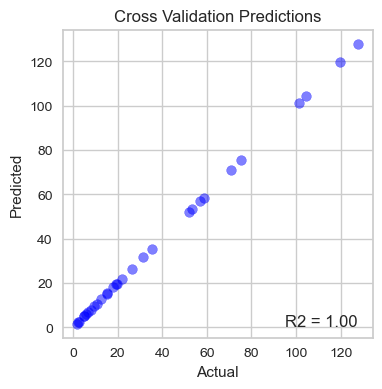

In [2]:
dl = DataLoader(PATH, INPUT_VARS, RESPONSE_VARS)
dl.get_bounds()

cycle = 'DBTL_A'
cycle = 'all'

if cycle == 'DBTL_A':
    # Keep only DBTL_A indexes
    dl.df = dl.df[dl.df.index.isin(DBTL_A)]
    dl.X = dl.df[INPUT_VARS]
    dl.y = dl.df[RESPONSE_VARS]
    print(f"New data shape: {dl.df.shape}")

    try:
        dl.load_model("../models/xgb_limonene.pkl")
    except FileNotFoundError:
        dl.train_xgb(n_iter=300)
        dl.save_model("../models/xgb_limonene.pkl")

elif cycle == 'all':
    try:
        dl.load_model("../models/xgb_limonene_all.pkl")
    except FileNotFoundError:
        dl.train_xgb(n_iter=300)
        dl.save_model("../models/xgb_limonene_all.pkl")    
    
dl.plot_R2()

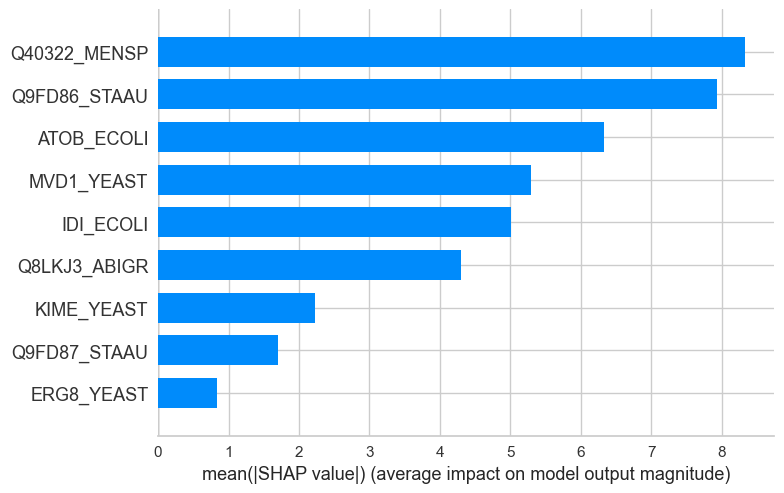

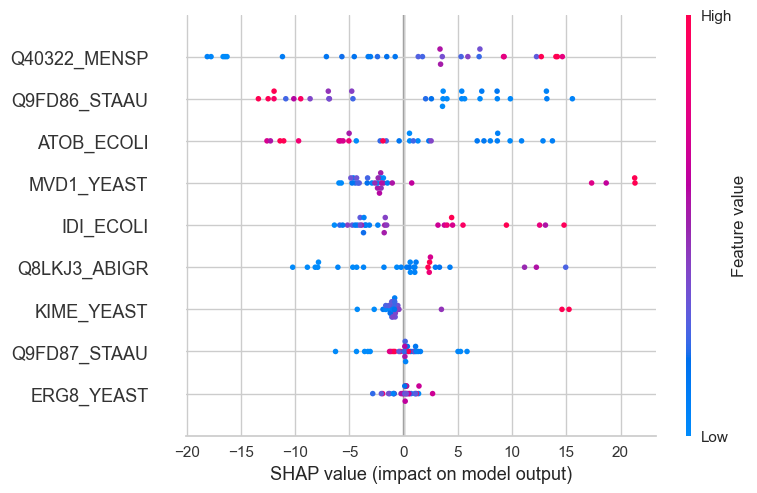

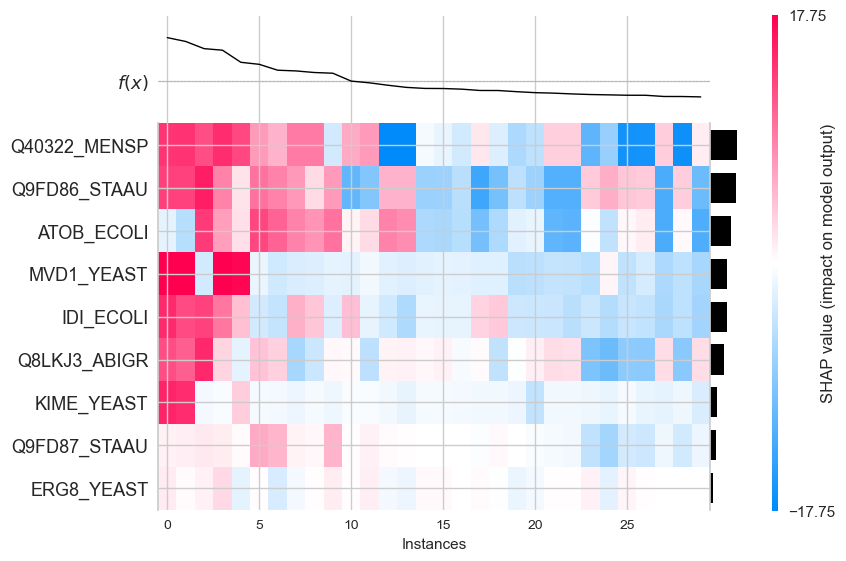

In [3]:
dl.get_shap_values()

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

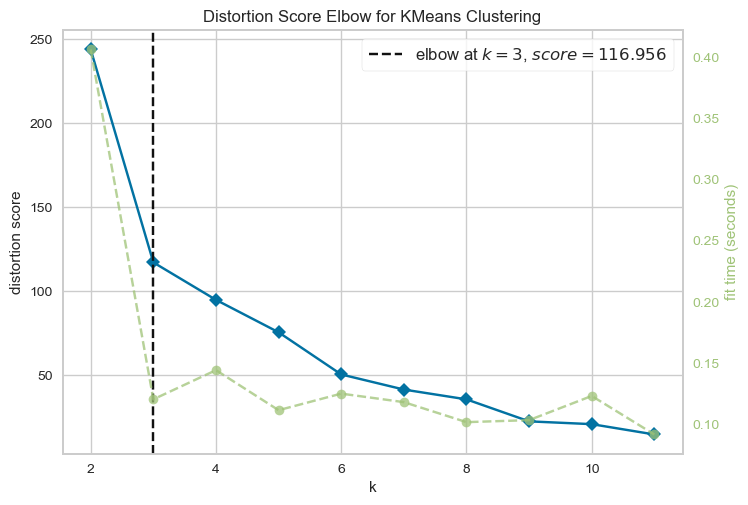

Optimal number of clusters: 3


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


In [4]:
dl.supervised_clustering()

In [5]:
dl.study_clusters()

Number of elements in each cluster: 
0    20
1     6
2     4
Name: cluster, dtype: int64


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
cluster,,,,,,,,,,
0,0.627986,0.606850,1.397032,0.257130,1.250631,3.645608,0.855999,1.515156,1.948642,13.701455
1,0.148900,0.479333,1.682750,0.226133,1.153867,5.501283,0.417750,0.305217,0.363517,66.139043
2,0.919183,0.775637,2.700712,0.812240,2.862687,11.337685,1.057567,0.485930,0.588510,106.101655


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
cluster,,,,,,,,,,
0,0.627986,0.606850,1.397032,0.257130,1.250631,3.645608,0.855999,1.515156,1.948642,13.701455
1,0.148900,0.479333,1.682750,0.226133,1.153867,5.501283,0.417750,0.305217,0.363517,66.139043
2,0.919183,0.775637,2.700712,0.812240,2.862687,11.337685,1.057567,0.485930,0.588510,106.101655


### Study top producting cluster

In [6]:
dl.df["pred"] = dl.model.predict(dl.df.drop(["Limonene", "cluster"], axis=1))
# find cluster with highest mean predicted value
top_cluster = (
    dl.df.groupby("cluster").mean().sort_values("pred", ascending=False).index[0]
)

dl.df[dl.df["cluster"] == top_cluster]

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene,cluster,pred
BL.Mm,1.25540,0.58985,2.29065,1.04860,3.19300,11.31405,1.63235,0.25975,0.41045,119.81367,2,119.818130
BL.Mh,1.95983,0.78130,2.59550,1.42496,4.10495,13.59919,1.86762,0.39057,0.65389,127.99494,2,127.988815
2X.Mm,0.22310,0.79010,2.73540,0.37440,1.95920,9.23380,0.43350,0.51180,0.54090,101.20540,2,101.200211
2X.Mh,0.23840,0.94130,3.18130,0.40100,2.19360,11.20370,0.29680,0.78160,0.74880,75.39261,2,75.392654


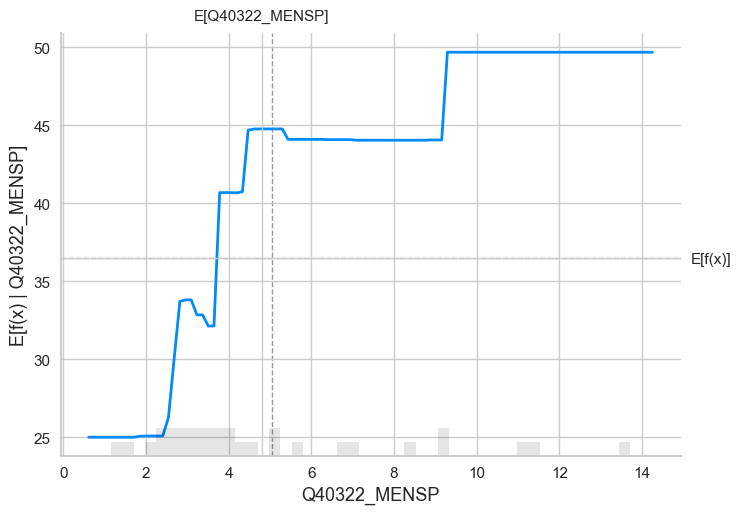

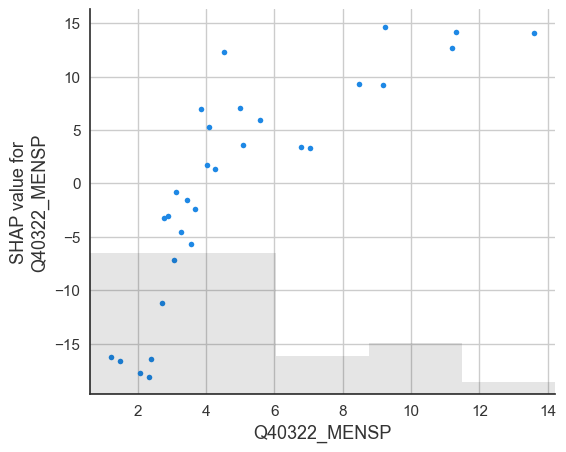

In [7]:
dl.pdplot("Q40322_MENSP")
dl.shap_scatter("Q40322_MENSP")

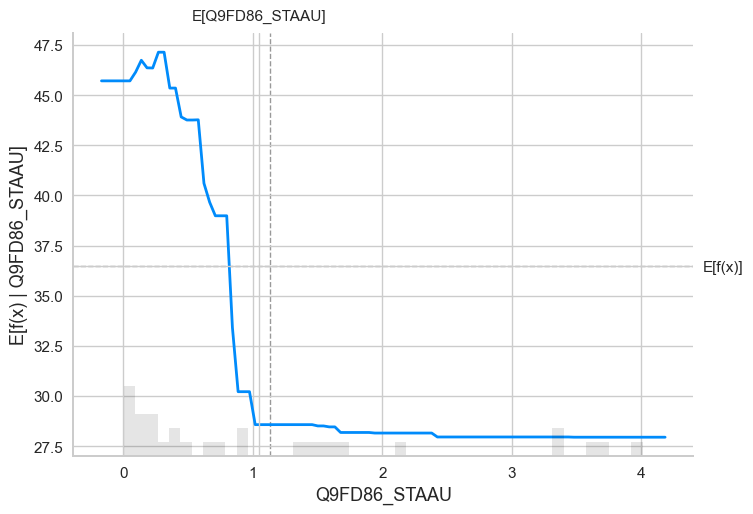

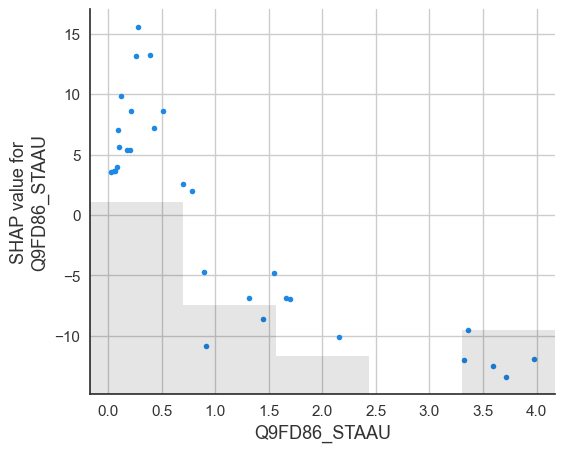

In [8]:
dl.pdplot("Q9FD86_STAAU")
dl.shap_scatter("Q9FD86_STAAU")

## Sampling

In [17]:
from scipy.stats import qmc

# Rearrange bounds to match input variables
# dl.bounds['Q40322_MENSP'].loc['min'] = 14
# dl.bounds['Q9FD86_STAAU'].loc['max'] = 0.3
# dl.bounds['ERG8_YEAST'].loc['max'] = 0.5


sampler = qmc.LatinHypercube(d=dl.X.shape[1])
sample = sampler.random(100)
LB = dl.bounds.T['min'].values.tolist()
UB = dl.bounds.T['max'].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=dl.X.columns)
sample_df["pred"] = dl.model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
41,1.938372,1.248764,2.462233,1.271764,4.133677,12.179540,0.809520,0.156426,3.460323,116.259338
91,2.026512,0.418433,3.129190,1.036203,2.701699,7.918443,1.582517,0.193411,2.985382,114.126556
4,0.243979,0.369252,2.551824,1.093513,4.094291,3.052806,2.476459,0.575416,0.593604,102.457954
70,1.393782,0.297910,2.514417,0.682372,2.928514,5.369559,3.816225,0.262426,5.218869,97.461006
32,0.642888,1.345800,2.152082,1.483096,3.307913,5.165254,2.623792,0.679271,2.565769,95.567780
...,...,...,...,...,...,...,...,...,...,...
44,0.834677,0.680247,0.884300,0.647176,0.767845,4.455108,0.618910,1.449689,0.560948,20.816084
75,1.413559,0.428203,1.691682,0.422557,0.506614,0.724528,1.862617,0.538776,3.563447,18.842703
53,0.592937,0.924288,2.329537,0.290749,0.409394,1.105137,0.119972,0.616446,1.979649,18.522526
96,1.337166,1.156232,1.231165,0.350305,0.568448,10.475998,0.411376,2.581582,0.963714,16.256069
